In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai import *
from fastai.tabular import *
from fastai.tabular.all import *


import pydicom

import pandas as pd


# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv")
test_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv")

print(len(train_df), len(test_df))

33126 10982


In [4]:
train_df['benign_malignant'] = train_df['benign_malignant'].apply(lambda x : 0 if (x == "benign") else 1)
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,0,0


In [5]:
train_df = train_df.drop(['patient_id'],axis=1)
dummy1 = pd.get_dummies(train_df['sex'], drop_first=True)
train_df = pd.concat([train_df, dummy1], axis=1).drop('sex', axis=1)
train_df.head()
dummy2 = pd.get_dummies(train_df['anatom_site_general_challenge'])
train_df = pd.concat([train_df, dummy2], axis=1).drop('anatom_site_general_challenge', axis=1)
train_df.head()
train_df = train_df.drop("diagnosis", axis=1)
train_df = train_df.drop("target", axis=1)
train_df["age_approx"] = train_df["age_approx"].fillna(train_df["age_approx"].mean()) # fillna null value in Math column with mean of the Math

In [6]:
train_df

,image_name,age_approx,benign_malignant,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,ISIC_2637011,45.0,0,1,1,0,0,0,0,0
1,ISIC_0015719,45.0,0,0,0,0,0,0,0,1
2,ISIC_0052212,50.0,0,0,0,1,0,0,0,0
3,ISIC_0068279,45.0,0,0,1,0,0,0,0,0
4,ISIC_0074268,55.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,50.0,0,1,0,0,0,0,1,0
33122,ISIC_9999320,65.0,0,1,0,0,0,0,1,0
33123,ISIC_9999515,20.0,0,1,0,1,0,0,0,0
33124,ISIC_9999666,50.0,0,1,0,1,0,0,0,0


In [7]:
train_df['benign_malignant'].value_counts()

0    32542
1      584
Name: benign_malignant, dtype: int64

In [8]:
mal_ims = train_df[train_df['benign_malignant']==1]
n_mal_ims = len(mal_ims)
print("Number of malignant images: {}".format(n_mal_ims))
mal_ims.head()

#create a df of a subset of benevolent images
ben_ims_subset = train_df[train_df['benign_malignant']==0].sample(n=n_mal_ims, random_state=42)
n_ben_ims = len(ben_ims_subset)
print("Number of benign images in subset: {}".format(n_ben_ims))

#concatenate the two together and check the result
train_df = pd.concat([mal_ims, ben_ims_subset], axis=0)
train_df.head()

Number of malignant images: 584
Number of benign images in subset: 584


,image_name,age_approx,benign_malignant,male,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
91,ISIC_0149568,55.0,1,0,0,0,0,0,0,1
235,ISIC_0188432,50.0,1,0,0,0,0,0,0,1
314,ISIC_0207268,55.0,1,1,0,0,0,0,1,0
399,ISIC_0232101,65.0,1,1,0,0,0,0,1,0
459,ISIC_0247330,65.0,1,0,0,1,0,0,0,0


In [9]:
# means = [train_df[col].mean() for col in train_df.drop(['image_name', 'benign_malignant'], axis=1)]
# std_devs = [train_df[col].std() for col in train_df.drop(['image_name', 'benign_malignant'], axis=1)]

means = train_df['age_approx'].mean()
std_devs = train_df['age_approx'].std()
print(means)
print(std_devs)

53.1145034526283
16.078023125428384


In [10]:
import tensorflow as tf

def stat_scaler(tensor):
     return (tensor - means) / std_devs

stat_scaler(tf.constant([1, 2, 3, 4, 5, 6, 7, 8], dtype=tf.float32))

2023-01-19 20:59:40.856336: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-3.24135  , -3.1791532, -3.1169565, -3.0547597, -2.9925632,
       -2.9303665, -2.8681698, -2.805973 ], dtype=float32)>

In [11]:
train = train_df.sample(frac = 0.9)

rest = train_df.drop(train.index)

val = rest.sample(frac = 0.5)

test = rest.drop(val.index)

In [12]:
train_df = train[:1000]
val_df = val[:50]
test_df = test[:50]

print("train:", len(train_df))
print("val:", len(val_df))
print("test:", len(test_df))

train: 1000
val: 50
test: 50


In [13]:
import pydicom as dicom
import cv2   
import numpy as np
from PIL import Image as im
from numpy import asarray

path_imgs = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"

def read_dicom_image(img_name):
    img_path = os.path.join(path_imgs + img_name + ".jpg")
    image = cv2.imread(img_path)
    image = im.fromarray(image)
    image = image.resize((224,224))
    image = asarray(image)
    return image

In [14]:
read_dicom_image("ISIC_2637011").shape

(224, 224, 3)

In [15]:
#Install sitk library to read dicom files
!pip install SimpleITK  
import pandas as pd
import os
import SimpleITK as sitk
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [16]:
class getImages(Dataset):
    def __init__(self, frame, id_col):

        self.frame = frame
        self.id_col = id_col

    def __len__(self):
        return (self.frame.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #complete image path and read
        img_name = self.frame[self.id_col].iloc[idx]
        image = read_dicom_image(img_name)

        return image

In [17]:
train_imgs = getImages(train_df, 'image_name')
val_imgs = getImages(val_df, 'image_name')
test_imgs = getImages(test_df, 'image_name')

In [18]:
image1 = train_imgs[0]
train_images = []
if test is None:
    print(f'This image is bad')
else:
    train_images.append(image1)
train_images = np.array(train_images)
for i in range(1, len(train_imgs)):
    train_images = np.vstack([train_images, [train_imgs[i]]])
    
image1 = val_imgs[0]
val_images = []
if test is None:
    print(f'This image is bad')
else:
    val_images.append(image1)
val_images = np.array(val_images)
for i in range(1, len(val_imgs)):
    val_images = np.vstack([val_images, [val_imgs[i]]])
    
image1 = test_imgs[0]
test_images = []
if test is None:
    print(f'This image is bad')
else:
    test_images.append(image1)
test_images = np.array(test_images)
for i in range(1, len(test_imgs)):
    test_images = np.vstack([test_images, [test_imgs[i]]])

In [19]:
train_feats  = np.array(train_df[['age_approx','male', 'head/neck', 'lower extremity', 'oral/genital', 'palms/soles', 'torso', 'upper extremity']])
val_feats  = np.array(val_df[['age_approx','male', 'head/neck', 'lower extremity', 'oral/genital', 'palms/soles', 'torso', 'upper extremity']])
test_feats  = np.array(test_df[['age_approx','male', 'head/neck', 'lower extremity', 'oral/genital', 'palms/soles', 'torso', 'upper extremity']])

train_labels = np.array(train_df['benign_malignant'])
val_labels = np.array(val_df['benign_malignant'])
test_labels = np.array(test_df['benign_malignant'])

In [20]:
print("train_data")
print("images shape:", train_images.shape)
print("feats shape:", train_feats.shape)
print("labels shape:", train_labels.shape)

print("")
print("val_data")
print("images shape:", val_images.shape)
print("feats shape:", val_feats.shape)
print("labels shape:", val_labels.shape)

print("")
print("test_data")
print("images shape:", test_images.shape)
print("feats shape:", test_feats.shape)
print("labels shape:", test_labels.shape)

train_data
images shape: (1000, 224, 224, 3)
feats shape: (1000, 8)
labels shape: (1000,)

val_data
images shape: (50, 224, 224, 3)
feats shape: (50, 8)
labels shape: (50,)

test_data
images shape: (50, 224, 224, 3)
feats shape: (50, 8)
labels shape: (50,)


<span style="font-size:32px; font-family:Verdana"> CNN Model with Just Pictures (Baseline) </span>

In [21]:
# Define the Model

from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import regularizers

input_pic = layers.Input(shape=(224, 224, 3))
x         = layers.Lambda(preprocess_input)(input_pic)
x         = MobileNetV2(input_shape=((224, 224, 3)), include_top=False, weights='imagenet')(x)
x.trainable = False
x         = layers.GlobalAveragePooling2D()(x)
x         = layers.Flatten()(x)
x         = layers.Dense(10, kernel_regularizer=regularizers.L2(0.1),activity_regularizer=regularizers.L1(0.1), activation='relu')(x)
x         = layers.Dense(1, activation='sigmoid')(x)
model     = Model(inputs=input_pic, outputs=x)

9420800/9406464 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11    

In [23]:
from tensorflow.keras.optimizers import Adam

learning_rate = .0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [24]:
history = model.fit(x= train_images, y = train_labels,
          validation_data = (val_images, val_labels),
          batch_size= 100,
          epochs=8,
          verbose=2)

2023-01-19 21:06:24.816271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8
10/10 - 77s - loss: 2.7945 - accuracy: 0.6420 - val_loss: 3.2256 - val_accuracy: 0.5400
Epoch 2/8
10/10 - 65s - loss: 2.5239 - accuracy: 0.8310 - val_loss: 3.2721 - val_accuracy: 0.6000
Epoch 3/8
10/10 - 65s - loss: 2.4177 - accuracy: 0.8630 - val_loss: 3.1922 - val_accuracy: 0.6000
Epoch 4/8
10/10 - 64s - loss: 2.3342 - accuracy: 0.8910 - val_loss: 3.0198 - val_accuracy: 0.6000
Epoch 5/8
10/10 - 64s - loss: 2.2481 - accuracy: 0.9270 - val_loss: 2.8571 - val_accuracy: 0.6800
Epoch 6/8
10/10 - 64s - loss: 2.1746 - accuracy: 0.9500 - val_loss: 2.7492 - val_accuracy: 0.7800
Epoch 7/8
10/10 - 64s - loss: 2.1005 - accuracy: 0.9580 - val_loss: 2.7273 - val_accuracy: 0.7800
Epoch 8/8
10/10 - 64s - loss: 2.0315 - accuracy: 0.9700 - val_loss: 2.6770 - val_accuracy: 0.8000


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


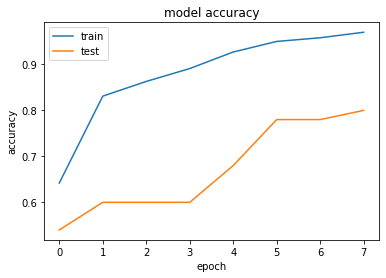

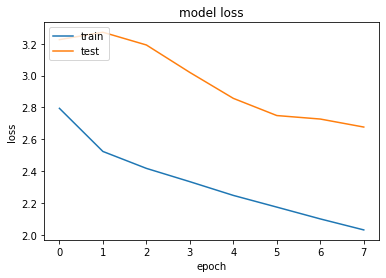

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<span style="font-size:32px; font-family:Verdana"> Multi-input Model </span>

In [74]:
# Define the Model

from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import regularizers

# Define the Picture (CNN) Stream

input_pic = layers.Input(shape=(224, 224, 3))
x         = layers.Lambda(preprocess_input)(input_pic)
x         = MobileNetV2(input_shape=((224, 224, 3)), include_top=False, weights='imagenet')(x)
x.        trainable = False
x         = layers.GlobalAveragePooling2D()(x)
x         = layers.Flatten()(x)
x         = layers.Dense(10, kernel_regularizer=regularizers.L2(0.1),activity_regularizer=regularizers.L1(0.1), activation='relu')(x)
x         = Model(inputs=input_pic, outputs=x)

# Define the Stats (Feed-Forward) Stream

input_stats = layers.Input(shape=(8,))
# y = layers.Lambda(stat_scaler)(input_stats)
y = input_stats
y = layers.Dense(32, kernel_regularizer=regularizers.L2(0.1),
    activity_regularizer=regularizers.L1(.1), activation="relu")(y)
# y = layers.Dense(32, activation="relu")(y)
y = layers.Dense(2, activation="relu")(y)
y = Model(inputs=input_stats, outputs=y)

# Concatenate the two streams together
combined = layers.concatenate([x.output, y.output])

# Define joined Feed-Forward Layer
z = layers.Dense(5, activation="relu")(combined)

# Define output node of 1 linear neuron (regression task)
z = layers.Dense(1, activation="sigmoid")(z)

# Define the final model
model = Model(inputs=[x.input, y.input], outputs=z)

In [77]:
from tensorflow.keras.optimizers import Adam

learning_rate = .0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint('model/', save_best_only=True)

history = model.fit(x=[train_images, train_feats], y = train_labels,
          validation_data=([val_images, val_feats], val_labels),
          batch_size= 100,
          epochs=10,
          verbose=2,
          callbacks=[cp])        

Epoch 1/10
10/10 - 71s - loss: 24.9003 - accuracy: 0.6250 - val_loss: 25.3243 - val_accuracy: 0.6600


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
10/10 - 64s - loss: 24.6819 - accuracy: 0.6900 - val_loss: 25.5341 - val_accuracy: 0.6400
Epoch 3/10
10/10 - 64s - loss: 24.4751 - accuracy: 0.7890 - val_loss: 25.4844 - val_accuracy: 0.6000
Epoch 4/10
10/10 - 64s - loss: 24.2639 - accuracy: 0.8430 - val_loss: 25.4632 - val_accuracy: 0.5200
Epoch 5/10
10/10 - 64s - loss: 24.0534 - accuracy: 0.8840 - val_loss: 25.3634 - val_accuracy: 0.5200
Epoch 6/10
10/10 - 65s - loss: 23.8490 - accuracy: 0.9180 - val_loss: 25.2029 - val_accuracy: 0.5200


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/10
10/10 - 65s - loss: 23.6538 - accuracy: 0.9390 - val_loss: 25.0175 - val_accuracy: 0.5400


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10
10/10 - 65s - loss: 23.4634 - accuracy: 0.9530 - val_loss: 24.8842 - val_accuracy: 0.5600


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/10
10/10 - 65s - loss: 23.2771 - accuracy: 0.9620 - val_loss: 24.7940 - val_accuracy: 0.5400


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/10
10/10 - 64s - loss: 23.0972 - accuracy: 0.9590 - val_loss: 24.6531 - val_accuracy: 0.5200


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


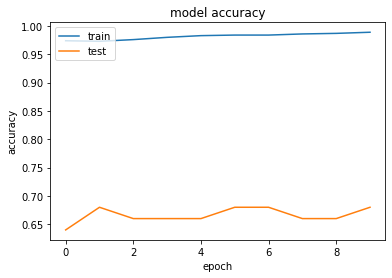

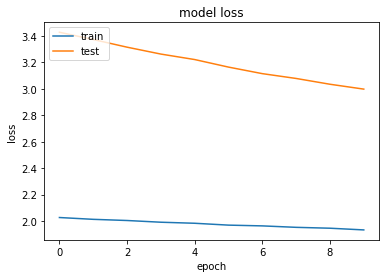

In [62]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
test_predictions = model.predict([test_images, test_feats])
test_predictions[:10]

array([[0.66203415],
       [0.68206567],
       [0.59343743],
       [0.6531695 ],
       [0.6479127 ],
       [0.4080531 ],
       [0.83251435],
       [0.29038644],
       [0.47007835],
       [0.78156567]], dtype=float32)

In [53]:
for i in range(len(test_predictions)):
    if (test_predictions[i][0]>0.5):
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0
test_predictions

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=test_labels, y_pred=test_predictions)

In [55]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[13  7]
 [13 17]]


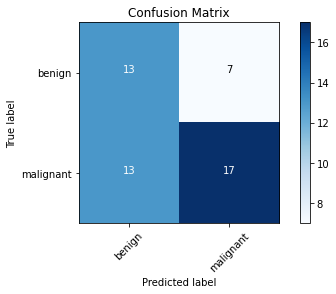

In [56]:
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[13  7]
 [13 17]]
Sensitivity:  0.5
Specificity:  0.7083333333333334
Positive Predictive Value:  0.65
Negative Predicitve Value:  0.5666666666666667
Accuracy:  0.6


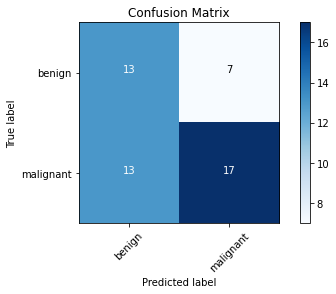

In [57]:
cm = confusion_matrix(y_true=test_labels, y_pred=test_predictions)
cm_plot_labels = ['benign','malignant']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

sensitivity = tp/(tp + fn)
specificity = tn/(fp + tn)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
accuracy = (tp + tn)/(tp + fp + fn + tn)

print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Positive Predictive Value: ", ppv)
print("Negative Predicitve Value: ", npv)
print("Accuracy: ", accuracy)